In [115]:
%matplotlib inline

In [87]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from astropy.io import votable as vot
from astroquery.vizier import Vizier
#catalog_list = Vizier.find_catalogs('Kang W51')

#we must set
Vizier.ROW_LIMIT = -1  #needed to bypass the 50 rows limit

#and if we read again...
DaRio2009_table2 = Vizier.get_catalogs('J/ApJS/183/261/table2')



In [3]:
operator = "robberto"

## Define function to calculate angular separation

In [27]:
def angsep(ra1deg,dec1deg,ra2deg,dec2deg):
    """ Determine separation in degrees between two celestial objects 
        arguments are RA and Dec in decimal degrees. 
        Returns the separation in decimal degrees.
    """
    ra1rad=ra1deg*np.pi/180.      #from decimal degrees to radiants...
    dec1rad=dec1deg*np.pi/180.
    ra2rad=ra2deg*np.pi/180.
    dec2rad=dec2deg*np.pi/180.
    
    # calculate scalar product for determination
    # of angular separation, all in radiants
    
    x=np.cos(ra1rad)*np.cos(dec1rad)*np.cos(ra2rad)*np.cos(dec2rad)
    y=np.sin(ra1rad)*np.cos(dec1rad)*np.sin(ra2rad)*np.cos(dec2rad)
    z=np.sin(dec1rad)*np.sin(dec2rad)
    
    rad=np.arccos(x+y+z) # Sometimes gives warnings when coords match
    
    # use Pythargoras approximation if rad < 1 arcsec = 1/206265. radiants = 4.848E-6 radiants
    sep = np.choose( rad<0.000004848 , (np.sqrt((np.cos(dec1rad)*(ra1rad-ra2rad))**2+(dec1rad-dec2rad)**2),rad))
        
    # Angular separation
    sep=sep*180./np.pi   #convert from radiants back to decimal degrees

    return sep



## Read the WFC3 data

In [79]:
#read the WFC3 slim catalog
rawpath_ir = "/Users/"+operator+"/Box Sync/Orion/photometry/Final_catalogue"
fileWFC3 = rawpath_ir + '/slim_table.csv'
data_ir = np.genfromtxt(fileWFC3,names=True,delimiter=',')
print len(data_ir)
type(data_ir)

5299


numpy.ndarray

In [67]:
print(data_ir[100])

(100.0, 83.65692266, -5.439306621, 9260.612146, 8467.958019, 13.8675, 0.002, 0.737, 0.0, 2.0, 13.5655, 0.001, 0.295, 0.0, 2.0, 127.0, 2.0)


In [46]:
#check to make sure we got the columns right
data_ir.dtype.names

('ind',
 'ra',
 'dec',
 'X_mos',
 'Y_mos',
 'mag130',
 'err_mag130',
 'delta130',
 'Flag_130',
 'N_130',
 'mag139',
 'err_mag139',
 'delta139',
 'Flag_139',
 'N_139',
 'FirstID',
 'N')

## Read the Hawk data


In [80]:
#read the WFC3 slim catalog
rawpath_catalogs = "/Users/"+operator+"/Box Sync/Orion/catalogs"
fileHawk = rawpath_catalogs + '/Orion_HAWK-I_catalog_to_publish.dat'
data_Hawk = np.genfromtxt(fileHawk, names=True)
print len(data_Hawk)
type(data_Hawk)

4340


numpy.ndarray

In [48]:
#check to make sure we got the columns right
data_Hawk.dtype.names

('RA2000', 'Dec2000', 'J_', 'Jerr', 'H', 'Herr', 'K', 'Kerr')

## Source Matching

### We look fo the conterparts of the WFC3IR sources

In [84]:
rair = data_ir['ra']
decir = data_ir['dec']
nir = len(decir) #number of individual stars in the WFC3 catalog: nir=5299
raHawk =data_Hawk['RA2000']
decHawk =data_Hawk['Dec2000']
nHawk = len(decHawk) #number of individual stars in the Hawk catalog: nHawk=4340
print(nHawk)


#array_final and index_nul are filled with -99.999 
array_final = np.ones((nHawk,13), dtype=np.float)*(-99.999)
index_null = np.ones((nHawk,8), dtype=np.float)*(-99.999)
#print array_final[:20]

4340


In [58]:
# test case
k=3500
dist = angsep(raHawk[k],decHawk[k],rair,decir)  #
print(len(dist))
min_dist = np.min(dist)  
print(min_dist)


5299
3.27119002276e-05


zero match, one match, two match:  2421 1648 271
more than 0 matches:  (array([], dtype=int64),)  0 matches:  2421
2618 5299


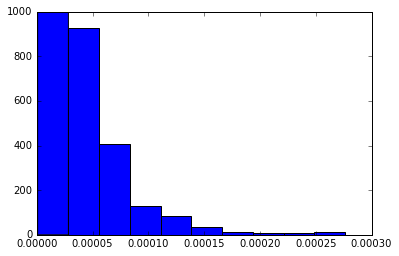

In [136]:
ii=0
j=0
num0=0
num1=0
num2=0
min_dist = np.ones(nHawk)   #3390 ACS stars

for k in range(nHawk):
    #calculate for each Hawk source the distance to all WFC3-IR sources
    dist = angsep(raHawk[k],decHawk[k],rair,decir)  #5299 distances, one for each WFC3-IR star
    min_dist[k] = np.min(dist)  
    #estimate minimum
    #CRITERION: coordinates can be off by 0.5"
    #0.5 ARCSEC = 0.5*1/3600. degrees
    criterion = 0.5/3600.
    i = np.where(dist < criterion)  #k is the Hawk index, i is the ir inder
    count = len(i[0])
    #print(count)
    if (count == 1): #found one and only one good match in the WFC3-IR list 
        num1=num1 + 1
        array_final[k,:] = [k, data_Hawk[k]['J_'],data_Hawk[k]['Jerr'], data_Hawk[k]['H'],data_Hawk[k]['Herr'], data_Hawk[k]['K'],data_Hawk[k]['Kerr'],
                            data_ir[i]['ra'],data_ir[i]['dec'],data_ir[i]['mag130'],data_ir[i]['err_mag130'],data_ir[i]['mag139'],data_ir[i]['err_mag139']]
#        array_final[k,:] = np.concatenate(data_ir[i],data_Hawk[k])
        ii=ii+1 
    if (count == 0):  # no good match found
        num0=num0+ 1
        #index_null[j,:] = [data_850[k]['IND'],data_850[k]['RA'],data_850[k]['DEC'],data_850[k]['X_MOS'],data_850[k]['Y_MOS'],data_850[k]['F775W'],data_850[k]['err_F775W'],data_850[k]['d_F775W'],data_850[k]['F850LP'],data_850[k]['err_F850LP'],data_850[k]['d_F850LP'],data_850[k]['ONCacs']]
        index_null[j,:] = data_Hawk[k]
        j=j+1
    if (count > 1):  # found more than one match
        num2=num2+ 1
        best1= np.where(dist[i] == min(dist[i]))
        #print(best1[0])
        if (len(best1[0]) > 1):
            best = best1[0][0]
        if (len(best1[0]) == 1):
            best =best1[0][0]
        #    print i[0][best]
        #array_final[i,:] = [data_850[k]['X_MOS'],data_850[k]['Y_MOS'],data_ir[b[0][best]]['ra'],data_ir[b[0][best]]['dec'],data_850[k]['F775W'],data_850[k]['err_F775W'],data_850[k]['F850LP'],data_850[k]['err_F850LP'],data_ir[b[0][best]]['mag139'],data_ir[b[0][best]]['err_mag139'],data_ir[b[0][best]]['mag130'],data_ir[b[0][best]]['err_mag130']] 
        #array_final[i,:] = [data_ir[i[0][best],data_Hawk[k]]]
        ii=ii+1

print 'zero match, one match, two match: ',num0, num1, num2
#print 'total = ',num0+num1+num2+len(np.where(visible == 0)[0])
print 'more than 0 matches: ', i,' 0 matches: ', j
plt.hist(min_dist[min_dist<2.77778E-4])   #max reange 1/3600. = 1 arcsec.
print len(min_dist[min_dist<2.77778E-4]), len(data_ir['ra'])  

In [137]:
array_final[250,0]

250.0

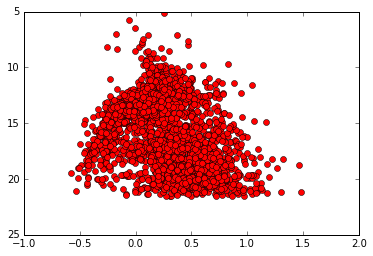

In [138]:
import matplotlib.pyplot as plt
plt.plot(array_final[:,9]-array_final[:,11] ,array_final[:,11] , 'ro')
plt.axis([-1, 2,25, 5])
plt.show()

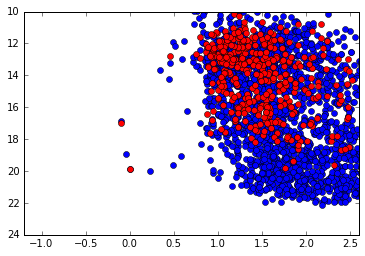

In [139]:
H2Oindex = array_final[:,9]-array_final[:,11]
iH2O = (H2Oindex<0).nonzero()
DM=8.15
plt.plot(array_final[:,1]-array_final[:,5] ,array_final[:,1], 'bo')
plt.plot(array_final[iH2O,1]-array_final[iH2O,5] ,array_final[iH2O,5], 'ro')
plt.axis([-1.2, 2.6,24, 10])
plt.show()

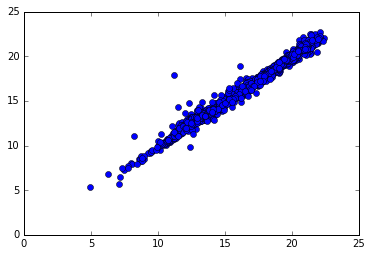

In [140]:
H2Oindex = array_final[:,9]-array_final[:,11]
iH2O = (H2Oindex<0).nonzero()
DM=8.15
plt.plot(array_final[:,1],array_final[:,9], 'bo')
plt.axis([0, 25,0, 25])
plt.show()

## Combine the two catalogs

In [11]:
# For convenience
ISPI_RA=ISPI['_RAJ2000']
ISPI_DE=ISPI['_DEJ2000']
WFI_RA=WFI['_RAJ2000']
WFI_DE=WFI['_DEJ2000']

In [12]:
#From the astropy manual
from astropy.coordinates import ICRS
from astropy import units as u

#assume ra1/dec1 and ra/dec2 are arrays loaded from some file
c_ISPI = ICRS(ISPI_RA, ISPI_DE, unit=(u.degree, u.degree))
c_WFI = ICRS(WFI_RA, WFI_DE, unit=(u.degree, u.degree))
idx, d2d, d3d = c_WFI.match_to_catalog_sky(c_ISPI)

/Users/robberto/anaconda/envs/astroconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/robberto/anaconda/envs/astroconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/robberto/anaconda/envs/astroconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/robberto/anaconda/envs/astroconda/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [13]:
#we have 2621 sources detected by WFI.
len(c_WFI)

2621

In [14]:
#the corresponding indices in the ISPI catalog (much larger) are give by the vector idx.
#We select the rows/sources corresponding to these indices
ISPI_matches = c_ISPI[idx]
#dra = (ISPI_matches.ra - c_WFI.ra).arcmin
#ddec = (ISPI_matches.dec - c_WFI.dec).arcmin

In [15]:
#The matching is agnostic about the minimum distance, some are bad. 
#We need to keep the good ones, selecting a discrepancy in coordinates of <1"
matched = d2d.arcsec < 1  #This is an array of 2621 TRUe/FALSE values
#these are the indices of the ISPI sources really matching the WFI catalog
m=idx[matched == True]

#v=list(range(len(c_WFI)))
#v
#v=v[matched == True]

In [16]:
#len(matched)
print(len(m))  #we pass from 2621 to 2426 paired sources
#print(m)

2426


In [1]:
ISPI=ISPI[m] #The new ISPI table is extracted with the indices of the good matches 
WFI=(WFI[matched]) #same for the WFI table

NameError: name 'ISPI' is not defined

## Create the table with the combined photometry

In [18]:
#This may be needed to get the right keywords
WFI.info()

<Table masked=True length=2426>
    name     dtype    unit  format                                               description                                                n_bad
----------- ------- ------- ------ -------------------------------------------------------------------------------------------------------- -----
   _RAJ2000 float64     deg  %9.5f               Right ascension (FK5, Equinox=J2000.0) (computed by VizieR, not part of the original data)     0
   _DEJ2000 float64     deg  %9.5f                   Declination (FK5, Equinox=J2000.0) (computed by VizieR, not part of the original data)     0
n__DRS2009_    str1                                     {\bf M} indicates M-type stars (table 4) and {\bf a} H{alpha} measurements (table5)     0
 __DRS2009_   int16                                                                                                   Identification number     0
    RAJ2000   str11 "h:m:s"                                                                 

/Users/robberto/anaconda/envs/astroconda/lib/python2.7/site-packages/astropy/table/info.py:94: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if np.all(info[name] == ''):


In [19]:
photometry=WFI['__DRS2009_','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','TiO','e_TiO','Ha','Imag','e_Imag']

In [20]:
#and to get the info for ISPI
#ISPI.info()

In [21]:
#add the ISPI measures to the final photometry table
photometry['Jmag']=ISPI['Jmag']
photometry['Hmag']=ISPI['Hmag']
photometry['Kmag']=ISPI['Kmag']
photometry['e_Jmag']=ISPI['e_Jmag']
photometry['e_Hmag']=ISPI['e_Hmag']
photometry['e_Kmag']=ISPI['e_Kmag']

#check
photometry



__DRS2009_,Umag,e_Umag,Bmag,e_Bmag,Vmag,e_Vmag,TiO,e_TiO,Ha,Imag,e_Imag,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag
,mag,mag,mag,mag,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag
int16,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32
1,--,--,16.093,0.004,13.728,0.004,12.097,0.003,0,8.626,0.027,6.143,4.778,4.493,0.020,0.020,0.270
2,9.886,0.008,10.041,0.009,9.736,0.008,9.540,0.004,5,8.822,0.021,8.067,7.604,7.380,0.026,0.034,0.023
3,13.260,0.007,12.141,0.011,11.246,0.017,10.535,0.003,24,9.280,0.036,8.166,7.539,7.190,0.029,0.044,0.021
4,11.081,0.005,10.697,0.009,10.219,0.010,9.929,0.004,-2,9.425,0.016,8.993,8.628,8.279,0.026,0.071,0.027
5,13.057,0.004,12.043,0.052,11.225,0.015,10.646,0.003,7,9.538,0.018,8.645,8.064,7.879,0.026,0.053,0.031
6,--,--,--,--,--,--,9.601,0.004,2,9.552,0.016,9.386,9.323,9.315,0.023,0.032,0.019
7,11.199,0.014,10.900,0.008,10.388,0.010,10.130,0.004,0,9.596,0.018,9.117,8.905,8.792,0.026,0.032,0.019
8,12.583,0.004,11.496,0.010,10.928,0.010,10.474,0.004,11,9.616,0.023,8.776,7.997,7.303,0.023,0.038,0.021


### Write the table

In [22]:
photometry.write('/Users/robberto/Box Sync/Orion/catalogs/Table WFI+ISPI.txt',format='ascii')

In [23]:
#and if you need to read it, you can use the Table environment of astropy
from astropy.table import Table
table=Table.read('/Users/robberto/Box Sync/Orion/catalogs/Table WFI+ISPI.txt',format='ascii')
table

__DRS2009_,Umag,e_Umag,Bmag,e_Bmag,Vmag,e_Vmag,TiO,e_TiO,Ha,Imag,e_Imag,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag
int64,str6,str5,str6,str5,str6,str5,str6,str5,int64,float64,float64,str7,str6,str6,str6,str5,str5
1,--,--,16.093,0.004,13.728,0.004,12.097,0.003,0,8.626,0.027,6.143,4.778,4.493,0.020,0.020,0.270
2,9.886,0.008,10.041,0.009,9.736,0.008,9.540,0.004,5,8.822,0.021,8.067,7.604,7.380,0.026,0.034,0.023
3,13.260,0.007,12.141,0.011,11.246,0.017,10.535,0.003,24,9.28,0.036,8.166,7.539,7.190,0.029,0.044,0.021
4,11.081,0.005,10.697,0.009,10.219,0.010,9.929,0.004,-2,9.425,0.016,8.993,8.628,8.279,0.026,0.071,0.027
5,13.057,0.004,12.043,0.052,11.225,0.015,10.646,0.003,7,9.538,0.018,8.645,8.064,7.879,0.026,0.053,0.031
6,--,--,--,--,--,--,9.601,0.004,2,9.552,0.016,9.386,9.323,9.315,0.023,0.032,0.019
7,11.199,0.014,10.900,0.008,10.388,0.010,10.130,0.004,0,9.596,0.018,9.117,8.905,8.792,0.026,0.032,0.019
8,12.583,0.004,11.496,0.010,10.928,0.010,10.474,0.004,11,9.616,0.023,8.776,7.997,7.303,0.023,0.038,0.021
9,9.928,0.021,10.075,0.026,10.122,0.012,9.908,0.006,18,9.652,0.019,8.680,8.500,8.380,0.110,0.010,0.110


### Inspect a source

In [24]:
import numpy as np
wl=np.array([0.35, 0.45, 0.55, 0.62, 0.658, 0.775, 1.2, 1.65, 2.2])
wl

array([ 0.35 ,  0.45 ,  0.55 ,  0.62 ,  0.658,  0.775,  1.2  ,  1.65 ,  2.2  ])

In [25]:
mags=photometry['Umag','Bmag','Vmag','TiO','Ha','Imag','Jmag','Hmag','Kmag']#[1]
star=mags[:][1]
print(star)

 Umag   Bmag   Vmag   TiO    Ha  Imag   Jmag   Hmag   Kmag 
 mag    mag    mag    mag        mag    mag    mag    mag  
------ ------ ------ ------ --- ------ ------ ------ ------
 9.886 10.041  9.736  9.540   5  8.822  8.067  7.604  7.380


In [26]:
import pandas as pd
photom=pd.read_csv('/Users/robberto/Box Sync/Orion/catalogs/Table WFI+ISPI.txt',delim_whitespace=True)
star=photom[['Umag','Bmag','Vmag','TiO','Ha','Imag','Jmag','Hmag','Kmag']]
star=star[1:2]
star=np.asarray(star,dtype=float)
star=np.squeeze(star)
star

array([  9.886,  10.041,   9.736,   9.54 ,   5.   ,   8.822,   8.067,
         7.604,   7.38 ])

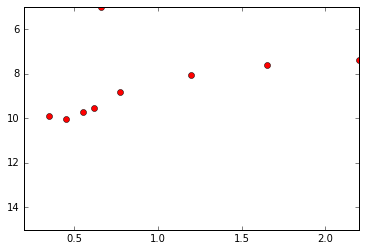

In [27]:
import matplotlib.pyplot as plt
plt.plot(wl, star , 'ro')
plt.axis([0.2, 2.2,15, 5])
plt.show()